In [1]:
import crocoddyl
import pinocchio
from IPython.display import HTML
import mim_solvers
import numpy as np
import random
from matplotlib import animation
from matplotlib import pyplot as plt
from PointMass_utils import *
from PointMass_model import DifferentialActionModelPointMass

In [2]:
nq = 2; nv = 2; nx = 4
nu = 2
T = 50
start_point = np.array([0, 0, 0, 0])
target_low = np.array([10, 0, 0, 0])
target_high = np.array([10, 10, 0, 0])
obs0 = Obstacle(5, 5, 2, 1, 'Obs0')
obs1 = Obstacle(3.5, 3.5, 1, 1, 'Obs1')
obs2 = Obstacle(6.5, 6.5, 1, 1, 'Obs2')
obs3 = Obstacle(6.5, 3.5, 1, 1, 'Obs3')
obs_set = [obs1, obs2, obs3]
translation_cost = XReg(nx, target_high[:nx], 'trans_high')
xreg = XReg(nx, start_point, 'XReg')
ureg = UReg(nu, None, 'UReg')

cost_set = Costs()
cost_set.add_cost(translation_cost)
# cost_set.add_cost(xreg)
# cost_set.add_cost(ureg)
# cost_set.add_cost(obs0)
cost_set.add_cost(obs1)
cost_set.add_cost(obs2)
cost_set.add_cost(obs3)

nr = cost_set.nr

In [3]:
# Desired Running and Terminal Model
w_run = np.array([10, 500, 500, 200])
w_term = np.array([1000, 500, 500, 200])
w_des = (np.hstack([w_run, w_term])/(np.max(np.hstack([w_run, w_term])))).copy()
# w_des = np.hstack([w_run, w_term])
w_run = w_des[:nr]; w_term = w_des[nr:]
PM_DAM_running = DifferentialActionModelPointMass(cost_set, w_run)
PM_DAM_terminal = DifferentialActionModelPointMass(cost_set, w_term)
pmDataRunning = PM_DAM_running.createData()
pmDataTerminal = PM_DAM_terminal.createData()
PM_ND_R = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_running, False)
PM_ND_T = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_terminal, False)
timeStep = 5e-2
PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND_R, timeStep)
PM_IAM_T = crocoddyl.IntegratedActionModelEuler(PM_ND_T, 0.0)
x0 = np.array([0.0, 0.0, 0.0, 0.0])
u0 = np.array([0.0, 0.0])
problem = crocoddyl.ShootingProblem(x0, [PM_IAM] * T, PM_IAM_T)
# Creating the SQP solver
sqp_opt = mim_solvers.SolverSQP(problem)
sqp_opt.setCallbacks([crocoddyl.CallbackVerbose()])
sqp_opt.with_callbacks=True
sqp_opt.termination_tolerance = 1e-5
xs_init = [x0 for i in range(T+1)]
us_init = [u0 for i in range(T)]

# Solving this problem
done = sqp_opt.solve(xs_init, us_init, 500)
xs_optimal = np.stack(sqp_opt.xs.tolist().copy())
us_optimal = np.stack(sqp_opt.us.tolist().copy())
print(done)

iter     merit         cost         grad      step    ||gaps||        KKT
   1  1.02500e+02  1.02500e+02  3.68493e+01  1.0000  0.00000e+00  9.98278e+00
   2  1.42478e+00  1.42478e+00  1.28352e-02  1.0000  3.05311e-14  3.92439e-03
   3  1.42456e+00  1.42456e+00  1.12979e-02  1.0000  2.08847e-11  2.83009e-03
   4  1.42438e+00  1.42438e+00  1.00797e-02  1.0000  1.77597e-11  2.54003e-03
   5  1.42423e+00  1.42423e+00  1.06188e-03  1.0000  2.13386e-11  5.63264e-04
   6  1.42422e+00  1.42422e+00  1.15581e-02  1.0000  1.85828e-12  8.06546e-03
   7  1.42407e+00  1.42407e+00  1.04776e-03  1.0000  1.94904e-11  3.95658e-03
   8  1.42405e+00  1.42405e+00  1.04358e-03  1.0000  1.85438e-12  4.09454e-03
   9  1.42403e+00  1.42403e+00  3.20259e-03  1.0000  1.99568e-12  1.79717e-02
  10  1.42392e+00  1.42392e+00  2.95743e-03  1.0000  4.37430e-12  1.00394e-02
iter     merit         cost         grad      step    ||gaps||        KKT
  11  1.42381e+00  1.42381e+00  2.79995e-03  1.0000  4.87235e-12  5.2010

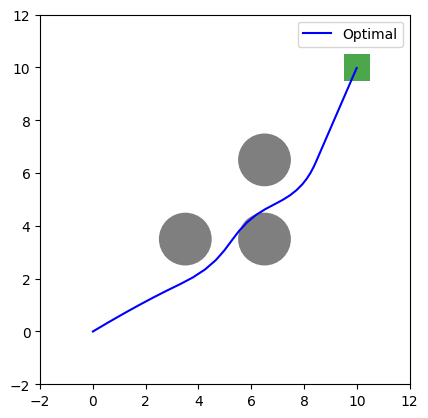

In [4]:
# HTML(animatePointMass(xs_optimal, obs_set, target_high).to_jshtml())
plot_1_traj(xs_optimal, obs_set, target_high, label='Optimal', linemap = 'b')

In [5]:
sqp_opt.cost

1.1461714994634464

In [11]:
sqp_cost = 0.0
for i, (RD, RM) in enumerate(zip(sqp_opt.problem.runningDatas, sqp_opt.problem.runningModels)):
    r = RD.differential.data_0.r
    sqp_cost += np.sum(0.5*RM.differential.model.costWeights*(r**2))*timeStep
r = sqp_opt.problem.terminalData.differential.data_0.r
sqp_cost += np.sum(0.5*sqp_opt.problem.terminalModel.differential.model.costWeights*(r**2))
print(sqp_cost)

1.1461714994634464


In [6]:
cost_set.traj_cost(sqp_opt.xs, sqp_opt.us, w_des[:nr], w_des[nr:], timeStep)

1.1461714994634464

In [189]:
from scipy.optimize import minimize
from scipy.optimize import Bounds

def fcn_w(x, alpha, mean):
    output = 0
    for a, m in zip(alpha, mean):
        output -= (np.exp(a**2))*np.exp(-(x-m)**2)
    return output

In [195]:
bound = Bounds(-np.inf, np.inf)
alpha = [1, 2, 4]
mean = [-1, 3, -5]
x0 = 0.0
options = {'maxiter': 500, 'iprint': -1,'ftol': 1e-25 ,'gtol' : 1e-25}
res = minimize(fcn_w, x0, tol = 1e-25, options=options, args=(alpha, mean), bounds=bound)
print('X: {}, FCN: {}'.format(res.x.item(), fcn_w(res.x.item(), alpha, mean)))

X: -5.000000005870465, FCN: -8886110.520508178


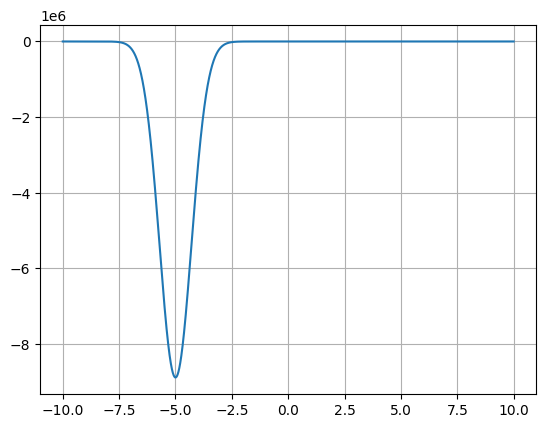

In [196]:
x = np.linspace(-10,10,10000)
y = [fcn_w(x[i], alpha, mean) for i in range(len(x))]
plt.plot(x,y)
plt.grid()
plt.show()

In [199]:
A = np.array([-1])
np.linalg.norm(A)

1.0

In [20]:
n = 4
A = np.ones(n) - np.identity(n)
print('values: ', np.linalg.eig(A)[0])
print('')
print('vectors: ', np.linalg.eig(A)[1])


values:  [-1.  3. -1. -1.]

vectors:  [[-0.8660254   0.5         0.32842618  0.10655131]
 [ 0.28867513  0.5        -0.85895877 -0.13142374]
 [ 0.28867513  0.5         0.18282338 -0.68436551]
 [ 0.28867513  0.5         0.3477092   0.70923795]]


In [21]:
np.linalg.det(A)

-2.9999999999999996